In [289]:
# celex_determine_compounds.ipynb
# H. Muller
# 2023-08-04

# Input: celex components
# Output: compounds in celex with information about morphological structure

In [290]:
from os import environ

# Parse arguments
if environ.get('lemma'):
    lemmaPath = environ.get('lemma')
else:
    lemmaPath = '../DataProcessed/dml.txt'
    
if environ.get('word'):
    wordPath = environ.get('word')
else:
    wordPath = '../DataProcessed/dmw.txt'  
    
if environ.get('phono'):
    phonoPath = environ.get('phono')
else:
    phonoPath = '../DataProcessed/dpw.txt' 
    
if environ.get('nl'):
    nlPath = environ.get('nl')
else:
    nlPath = '../DataProcessed/cgn_alignments_comp-o_nl.pkl'

if environ.get('vl'):
    vlPath = environ.get('vl')
else:
    vlPath = '../DataProcessed/cgn_alignments_comp-o_vl.pkl'

if environ.get('outfile'):
    outfile = environ.get('outfile')
else:
    outfile = '../DataProcessed/cgn_morph_analysis_comp-o.csv'

In [291]:
import pandas as pd

# Read files
lemma = pd.read_csv(lemmaPath, sep='\t', header=0, index_col=0)
word = pd.read_csv(wordPath, sep='\t', header=0, index_col=0)
phono = pd.read_csv(phonoPath, sep='\t', header=0, index_col=0)

# Determine compounds

In [292]:
lemma.head()

,IdNumLemma,Head,Inl,MorphStatus,MorphCnt,DerComp,Comp,Def,Imm,ImmSubCat,ImmAllo,ImmSubst,StrucLab,StrucAllo,StrucSubst,Sepa
0,1,a,1986,M,1,Y,Y,Y,a,N,N,N,(a)[N],N,N,N
1,2,a,1104,M,1,Y,Y,Y,a,P,N,N,(a)[P],N,N,N
2,3,Aafje,41,I,0,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,4,Aafke,4,I,0,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,5,Aagje,9,I,0,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [293]:
# add StrucLab to forms
lemma = lemma.fillna('')
word = word.fillna('')

word = word.merge(lemma[['IdNumLemma', 'StrucLab', 'Imm', 'ImmSubCat']], on='IdNumLemma', how='left')
word = word.loc[word['ImmSubCat']!='',]

word.head()

,IdNum,Word,Inl,IdNumLemma,FlectType,StrucLab,Imm,ImmSubCat
0,1,a,1962,1,e,(a)[N],a,N
1,2,a,1104,2,X,(a)[P],a,P
5,6,aagt,0,6,e,(aagt)[N],aagt,N
6,7,aagtappel,0,7,e,"((aagt)[N],(appel)[N])[N]",aagt+appel,NN
7,8,aagtappelen,0,7,m,"((aagt)[N],(appel)[N])[N]",aagt+appel,NN


In [294]:
# find all words that include [1-9A-Z]+x[1-9A-Z]
# but exclude words that include several interfixes [1-9A-Z]+x[1-9A-Z]+x[1-9A-Z]
compounds = word.loc[word.ImmSubCat.str.contains(r'^(?!.*[1-9A-Z]+x[1-9A-Z]+x[1-9A-Z]+).*[1-9A-Z]+x[1-9A-Z]+.*$'), ['Word', 'ImmSubCat']]
str(list(set(compounds.ImmSubCat.tolist())))

"['AxN', 'QNxN', 'Nx3', 'Ax1', 'Nx1x', '3xP', 'AxN3x', 'AxNx', 'BNxN', 'Nx3x', '7xA', 'NNxN', 'Ax2x', 'NxNx', 'NxNN', '3xA', '2xA', 'BxNx', 'Nx2N', 'PxNx', '3xN', 'BxN', 'PNxN', 'Nx2x', 'NxQ', 'NxAx', 'NxN', 'NNNxN', 'NxB', '2xN', 'ANxN', 'Nx3N', 'QxNx', 'AxP', 'ExN', '1xN', 'OxN', '7xN', 'NxA', 'Nx7x', 'PxN', 'AxN1x', '1x1', 'xNxN', '6xA', 'Nx1', '1x3', 'Nx7', 'AxNN', 'Nx2', 'Nx6x']"

In [295]:
# find noun-noun compounds
NxN = word.loc[word.ImmSubCat.str.contains(r'NxN'), ['Word', 'ImmSubCat']]
str(list(set(NxN.ImmSubCat.tolist())))

"['NxNx', 'QNxN', 'NxNN', 'AxNxN', 'NxNxN', 'PNxN', 'BNxN', 'NNNxN', 'NxN', 'NNxN', 'xNxN', 'ANxN']"

In [296]:
# remove compounds that are made of 2 or more compounds
NxN = NxN.loc[NxN.ImmSubCat.str.contains('NxNxN|AxNxN')==False,]
str(list(set(NxN.ImmSubCat.tolist())))

"['NxNx', 'QNxN', 'NxNN', 'PNxN', 'BNxN', 'NNNxN', 'NxN', 'NNxN', 'xNxN', 'ANxN']"

In [297]:
# make all lowercase list
NxN = list(set(NxN.Word.str.lower().to_list()))
print(f'number of compounds wih interfix in CELEX: {len(NxN)}')

number of compounds wih interfix in CELEX: 21933


# Find Compounds in CGN

In [298]:
# load netherlandic and belgian Dutch components
nl = pd.read_pickle(nlPath)
vl = pd.read_pickle(vlPath)

In [299]:
# add variables for identificiation of variant
nl['variant'] = 'Netherlandic'
vl['variant'] = 'Belgian'

# merge dutch and vlamish component
cgn = pd.concat([nl, vl])

# fill na's
cgn = cgn.fillna('')

# remove non-words
cgn = cgn.loc[cgn['WordOrtho']!='',]
cgn = cgn.loc[cgn['WordOrtho']!='_',]

# remove punctuation make words lower case
cgn.WordOrtho = cgn.WordOrtho.str.replace('\.', '', regex=True).str.replace('\?', '', regex=True)
cgn.WordOrtho = cgn.WordOrtho.str.lower()

In [300]:
# '-' and & belongs to word, '*' is a code used by CGN
print(cgn.loc[cgn.WordOrtho.str.contains("\&"), 'WordOrtho'].drop_duplicates().head())
print(cgn.loc[cgn.WordOrtho.str.contains("\*"), 'WordOrtho'].drop_duplicates().head())
print(cgn.loc[cgn.WordOrtho.str.contains("\-"), 'WordOrtho'].drop_duplicates().head())

608379    at&t
Name: WordOrtho, dtype: object
1973              liet*u
13363             ghee*v
14509         waringin*v
17141    geluksfiguren*u
17836         matthika*v
Name: WordOrtho, dtype: object
10910    zestiende-eeuwse
22680     amago-no-mikoto
23149              zi-xia
24137              armen-
24378               mens-
Name: WordOrtho, dtype: object


In [301]:
cgn.drop_duplicates(subset=['FileNameTierName', 'ID']).head()

,FileNameTierName,ID,WordOrtho,WordStart,WordEnd,WordPhono,Phone,PhoneStart,PhoneEnd,variant
0,fn001092.awdN00551,1-ik,ik,0.922,1.087,Ik,,0.000,0.922,Netherlandic
3,fn001092.awdN00551,2-vertelde,vertelde,1.087,1.529,f@rtEld@,f,1.087,1.138,Netherlandic
11,fn001092.awdN00551,3-meneer,meneer,1.529,1.786,m@ner,m,1.529,1.590,Netherlandic
16,fn001092.awdN00551,4-Wild,wild,1.786,2.125,wIlt,w,1.786,1.913,Netherlandic
20,fn001092.awdN00551,5-net,net,2.125,2.357,nEt,n,2.125,2.186,Netherlandic


# Clean dataframe

In [302]:
len(cgn)

3576814

In [303]:
# some words have no value in the phone column sometimes
cgn.loc[cgn.WordOrtho=='vruchtenbrandewijn',].head()

,FileNameTierName,ID,WordOrtho,WordStart,WordEnd,WordPhono,Phone,PhoneStart,PhoneEnd,variant
794463,fn001262.awdN00624,861-vruchtenbrandewijn.,vruchtenbrandewijn,360.688,361.81,=frYxt@brAnd@wE+n,,360.753,360.886,Netherlandic
794464,fn001262.awdN00624,861-vruchtenbrandewijn.,vruchtenbrandewijn,360.688,361.81,=frYxt@brAnd@wE+n,r,360.886,360.947,Netherlandic
794465,fn001262.awdN00624,861-vruchtenbrandewijn.,vruchtenbrandewijn,360.688,361.81,=frYxt@brAnd@wE+n,Y,360.947,361.028,Netherlandic
794466,fn001262.awdN00624,861-vruchtenbrandewijn.,vruchtenbrandewijn,360.688,361.81,=frYxt@brAnd@wE+n,x,361.028,361.099,Netherlandic
794467,fn001262.awdN00624,861-vruchtenbrandewijn.,vruchtenbrandewijn,360.688,361.81,=frYxt@brAnd@wE+n,t,361.099,361.170,Netherlandic


In [304]:
cgn.loc[cgn.Phone=='',]

,FileNameTierName,ID,WordOrtho,WordStart,WordEnd,WordPhono,Phone,PhoneStart,PhoneEnd,variant
0,fn001092.awdN00551,1-ik,ik,0.922,1.087,Ik,,0.000,0.922,Netherlandic
117,fn001092.awdN00551,33-terroriseert,terroriseert,10.978,11.835,tErorizerd,,11.764,11.835,Netherlandic
2564,fn001092.awdN00551,765-tamelijk,tamelijk,239.447,239.908,tam@l@k,,239.847,239.908,Netherlandic
2685,fn001092.awdN00551,805-zat,zat,250.737,251.071,zAd,,250.939,251.071,Netherlandic
2727,fn001092.awdN00551,821-had,had,254.955,255.137,hAd,,255.086,255.137,Netherlandic
...,...,...,...,...,...,...,...,...,...,...
1495521,fv800092.awdV80010,1-aan,aan,1.093,1.254,an,,0.000,1.093,Belgian
1496699,fv800093.awdV80010,1-Calderone,calderone,0.899,1.467,kAlderon@,,0.000,0.899,Belgian
1498007,fv800094.awdV80010,1-ze,ze,0.788,0.915,z@,,0.000,0.788,Belgian
1499243,fv800095.awdV80010,1-zonder,zonder,0.483,0.827,zOnd@r,,0.000,0.483,Belgian


In [305]:
# some words have a '=' or '-' in their phonemic transcription, but not in the phone column
print(cgn.loc[cgn.WordPhono=='=f@rAnd@rINsprosEs', ['WordOrtho', 'WordPhono', 'Phone', 'WordStart', 'PhoneStart', 'PhoneEnd']].drop_duplicates().head())
print(cgn.loc[cgn.WordPhono=='G@rExtsx@bA+-w', ['WordOrtho', 'WordPhono', 'Phone', 'WordStart', 'PhoneStart', 'PhoneEnd']].drop_duplicates().head())

                  WordOrtho           WordPhono Phone  WordStart  PhoneStart  \
1742404  veranderingsproces  =f@rAnd@rINsprosEs     @    279.234     279.295   
1742405  veranderingsproces  =f@rAnd@rINsprosEs     r    279.234     279.335   
1742406  veranderingsproces  =f@rAnd@rINsprosEs     A    279.234     279.386   
1742407  veranderingsproces  =f@rAnd@rINsprosEs     n    279.234     279.457   
1742408  veranderingsproces  =f@rAnd@rINsprosEs     d    279.234     279.498   

         PhoneEnd  
1742404   279.335  
1742405   279.386  
1742406   279.457  
1742407   279.498  
1742408   279.528  
         WordOrtho       WordPhono Phone  WordStart  PhoneStart  PhoneEnd
79  gerechtsgebouw  G@rExtsx@bA+-w     G      7.367       7.367      7.47
80  gerechtsgebouw  G@rExtsx@bA+-w     @      7.367       7.470      7.50
81  gerechtsgebouw  G@rExtsx@bA+-w     r      7.367       7.500      7.56
82  gerechtsgebouw  G@rExtsx@bA+-w     E      7.367       7.560      7.60
83  gerechtsgebouw  G@rExtsx@

In [306]:
# some words have multiple duplicated rows
duplis = cgn.duplicated(subset=['FileNameTierName', 'WordOrtho', 'WordPhono', 'Phone', 'PhoneStart', 'PhoneEnd'], keep=False)
cgn[duplis]

,FileNameTierName,ID,WordOrtho,WordStart,WordEnd,WordPhono,Phone,PhoneStart,PhoneEnd,variant


In [307]:
# fix those tokens
prior=len(cgn)
cgn = cgn.drop_duplicates(subset=['FileNameTierName', 'WordOrtho', 'WordPhono', 'Phone', 'PhoneStart', 'PhoneEnd'])
post=len(cgn)
print(f'{prior-post} rows removed. New number of rows: {post}')

0 rows removed. New number of rows: 3576814


In [308]:
# correct not matching boundaries
WordStart = (cgn.groupby(['FileNameTierName', 'ID'])['PhoneStart'].agg(lambda x: min(x)).reset_index(name='WordStart'))
WordEnd = (cgn.groupby(['FileNameTierName', 'ID'])['PhoneEnd'].agg(lambda x: max(x)).reset_index(name='WordEnd'))

# delete old columns
del cgn['WordStart']
del cgn['WordEnd']

# merge with new columns
cgn = cgn.merge(WordStart[['FileNameTierName', 'ID', 'WordStart']], on=['FileNameTierName', 'ID'], how='left')
cgn = cgn.merge(WordEnd[['FileNameTierName', 'ID', 'WordEnd']], on=['FileNameTierName', 'ID'], how='left')

# Compute speech rate

In [309]:
# compute utterance duration and utilize that each utterance's final ID ends with .
# find final ID in each utterance
cgn['UtteranceBorder'] = cgn.ID.str.endswith('.')

# Indicate start of new utterance
mask = cgn['UtteranceBorder']
shifted_mask = mask.shift(-1, fill_value=False)
cgn['UtteranceBorder'] = mask & ~shifted_mask
cgn['UtteranceBorder'] = cgn['UtteranceBorder'].shift(1)

# Groupby utterances and retrieve start and end of first and last phone
groups = (cgn['UtteranceBorder'] == True).cumsum()
cgn['UtteranceStart'] = cgn.groupby(groups)['PhoneStart'].transform('min')
cgn['UtteranceEnd'] = cgn.groupby(groups)['PhoneEnd'].transform('max')
cgn.drop_duplicates(['ID', 'UtteranceBorder']).head(10)

,FileNameTierName,ID,WordOrtho,WordPhono,Phone,PhoneStart,PhoneEnd,variant,WordStart,WordEnd,UtteranceBorder,UtteranceStart,UtteranceEnd
0,fn001092.awdN00551,1-ik,ik,Ik,,0.000,0.922,Netherlandic,0.000,1.087,NaN,0.0,4.014
1,fn001092.awdN00551,1-ik,ik,Ik,I,0.922,1.025,Netherlandic,0.000,1.087,False,0.0,4.014
3,fn001092.awdN00551,2-vertelde,vertelde,f@rtEld@,f,1.087,1.138,Netherlandic,1.087,1.529,False,0.0,4.014
11,fn001092.awdN00551,3-meneer,meneer,m@ner,m,1.529,1.590,Netherlandic,1.529,1.786,False,0.0,4.014
16,fn001092.awdN00551,4-Wild,wild,wIlt,w,1.786,1.913,Netherlandic,1.786,2.125,False,0.0,4.014
20,fn001092.awdN00551,5-net,net,nEt,n,2.125,2.186,Netherlandic,2.125,2.357,False,0.0,4.014
23,fn001092.awdN00551,6-over,over,ov@r,o,2.357,2.479,Netherlandic,2.357,2.630,False,0.0,4.014
27,fn001092.awdN00551,7-onze,onze,Onz@,O,2.630,2.691,Netherlandic,2.630,2.863,False,0.0,4.014
31,fn001092.awdN00551,8-ontsnapte,ontsnapte,OntsnApt@,O,2.863,2.923,Netherlandic,2.863,3.429,False,0.0,4.014
40,fn001092.awdN00551,9-baviaan.,baviaan,bAvijan,b,3.429,3.489,Netherlandic,3.429,4.014,False,0.0,4.014


In [310]:
# compute utterance duration
cgn['UtteranceDuration'] = cgn['UtteranceEnd'] - cgn['UtteranceStart']

## collect syllable number

In [311]:
# extract syllable numbers and remove unneeded information
syll = phono.copy()
syll['WordSylNum'] = syll.PhonStrsDISC.str.count('-') + 1
syll = syll[syll['WordSylNum'].notna()]
syll['WordOrthoLow'] = syll['Word'].str.lower()
syll = syll[['WordOrthoLow', 'WordSylNum']].drop_duplicates(['WordOrthoLow'])
syll.head()

,WordOrthoLow,WordSylNum
0,a,1.0
4,aagje,2.0
5,aagt,1.0
6,aagtappel,3.0
7,aagtappelen,4.0


In [312]:
# merge cgn with celex syllable numbers
cgn['WordOrthoLow'] = cgn.WordOrtho.str.lower()
cgn = cgn.merge(syll, on='WordOrthoLow', how='left')
cgn[['WordOrtho','WordSylNum']].head()

,WordOrtho,WordSylNum
0,ik,1.0
1,ik,1.0
2,ik,1.0
3,vertelde,3.0
4,vertelde,3.0


In [313]:
# some words do not occur in celex
cgn.loc[cgn.WordSylNum.isna(),['WordOrtho','WordSylNum']].drop_duplicates().head()

,WordOrtho,WordSylNum
49,camb,NaN
76,'ns,NaN
98,harry,NaN
164,één,NaN
289,'k,NaN


In [314]:
# some annotations contain exclamation marks. After reading the documentation of CGN, I still don't know what this means
cgn.loc[cgn.Phone.str.contains('!'),].head(100)

,FileNameTierName,ID,WordOrtho,WordPhono,Phone,PhoneStart,PhoneEnd,variant,WordStart,WordEnd,UtteranceBorder,UtteranceStart,UtteranceEnd,UtteranceDuration,WordOrthoLow,WordSylNum
24150,fn001098.awdN00555,828-!van de piramidale hiërarchie,!van de piramidale hiërarchie,!vAn d@ piramidal@ hij@rArxi,!vAn d@ piramidal@ hij@rArxi,356.794,358.203,Netherlandic,356.794,358.203,False,344.784,360.680,15.896,!van de piramidale hiërarchie,NaN
76183,fn001114.awdN00568,920-!ggg.,!ggg,!#,!#,272.749,273.326,Netherlandic,272.749,273.326,False,269.688,273.326,3.638,!ggg,NaN
96548,fn001119.awdN00570,1187-!ggg.,!ggg,!#,!#,453.142,453.830,Netherlandic,453.142,453.830,False,450.944,453.830,2.886,!ggg,NaN
154050,fn001134.awdN00634,624-!waar hij en zijn moeder op hun,!waar hij en zijn moeder op hun,!war hE+ En zE+n mud@r Op hYn,!war hE+ En zE+n mud@r Op hYn,223.519,224.797,Netherlandic,223.519,224.797,False,217.538,226.621,9.083,!waar hij en zijn moeder op hun,NaN
187975,fn001140.awdN00640,884-!zo zou kunnen uitbeelden en geen Cicero,!zo zou kunnen uitbeelden en geen cicero,!zo zA+w kYn@ Y+dbeld@ En xen sis@ro,!zo zA+w kYn@ Y+dbeld@ En xen sis@ro,295.869,298.101,Netherlandic,295.869,298.101,False,288.055,305.365,17.310,!zo zou kunnen uitbeelden en geen cicero,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187448,fv800118.awdV80012,4-!dat,!dat,!dAt,!d,1.179,1.220,Belgian,1.179,1.280,False,0.000,2.608,2.608,!dat,NaN
2187449,fv800118.awdV80012,4-!dat,!dat,!dAt,!A,1.220,1.250,Belgian,1.179,1.280,False,0.000,2.608,2.608,!dat,NaN
2187450,fv800118.awdV80012,4-!dat,!dat,!dAt,!t,1.250,1.280,Belgian,1.179,1.280,False,0.000,2.608,2.608,!dat,NaN
2187506,fv800118.awdV80012,25-!om,!om,!Om,!O,6.089,6.120,Belgian,6.089,6.162,False,3.370,10.420,7.050,!om,NaN


In [315]:
# exclamatation marks will be removed
cgn['Phone'] = cgn.Phone.str.replace('!', '')

In [316]:
# sometimes the phone column entails trainscriptions of the whole utterance
# for our purpose, it will be sufficient to annotate vowels and consonants that are described in the CGN docs
phones = sorted(list(set(cgn.Phone)))
phones

['',
 '#',
 '# #',
 '# a',
 '# mAk@l@k x@zExt',
 '# wAt sAl Ig blE+ zE+n',
 '2',
 '@',
 'A',
 'A+',
 'Arm@ # dan@l fIsh@r',
 'A~',
 'E',
 'E+',
 'E:',
 'En #',
 'En hE+ b@GOn fanatik t@ krAb@l@ Ik zA+w @t nit wet@',
 'E~',
 'G',
 'I',
 'Ik wAs nit mer t@ hAnthav@ Op mE+n',
 'J',
 'N',
 'O',
 'O:',
 'Ond@rwE+l b@sp2rd@ Ik',
 'OntwIk@l@ warme hE+ In @n Alfa romejo',
 'O~',
 'S',
 'Y',
 'Y+',
 'Y:',
 'Y~',
 'Z',
 '[]',
 'a',
 'b',
 'b@dENk dAn dAd_di nit somar',
 'd',
 'd@ b@rE+d@rs rip@ blAtsE+d@ zev@ mEt rYst@G@ stEm',
 'd@ twed@ #',
 'dAt #',
 'e',
 'f',
 'fest an t@ rIxt@ mEt myzik En dAns',
 'g',
 'h',
 'hE+ zIt Al d@ hel@ tE+t ja t@ knIk #',
 'i',
 'j',
 'j@ hEpt @n mId@lpYntsuk@nd@ OpstAnt En @n mId@lpYntflid@nd@ OpstAnt',
 'ja #',
 'ja # wAt sin z@ d@r x@men Y+t sEx',
 'k',
 'kOnd@ hYn oG@ bE+na nit x@lov@',
 'karl #',
 'l',
 'm',
 'mEd_d@ blIk # d@ xAN dor lip',
 'n',
 'o',
 'p',
 'profEsOr lAm@rs kE+kt f@rbast nar d@ mAn Op d@ stup fAn zE+n',
 'r',
 's',
 's mOrG@ns frux_xat hE+

In [317]:
# ascribe phone to vowels or consonants list
consonants = ['p', 't', 'b', 'd', 'k', 'g', 'f', 'v', 's', 'z', 'S', 'Z', 'x', 'G', 'h', 'N', 'm', 'n', 'J', 'l', 'r', 'w', 'j']
vowels = ['I', 'E', 'A', 'O', 'Y', 'i', 'y', 'e', '2', 'a', 'o', 'u', '@', 'E\+', 'Y\+', 'A\+', 'E\:', 'Y\:', 'O\:', 'E\~', 'A\~', 'O\~', 'Y\~']

# make regex expression
vowels = '(' + '|'.join(vowels) + ')'
consonants = '(' + '|'.join(consonants) + ')'

# check whether all phones were ascribed to consonants or vowels
[phone for phone in phones if phone not in consonants+vowels]

['#',
 '# #',
 '# a',
 '# mAk@l@k x@zExt',
 '# wAt sAl Ig blE+ zE+n',
 'A+',
 'Arm@ # dan@l fIsh@r',
 'A~',
 'E+',
 'E:',
 'En #',
 'En hE+ b@GOn fanatik t@ krAb@l@ Ik zA+w @t nit wet@',
 'E~',
 'Ik wAs nit mer t@ hAnthav@ Op mE+n',
 'O:',
 'Ond@rwE+l b@sp2rd@ Ik',
 'OntwIk@l@ warme hE+ In @n Alfa romejo',
 'O~',
 'Y+',
 'Y:',
 'Y~',
 '[]',
 'b@dENk dAn dAd_di nit somar',
 'd@ b@rE+d@rs rip@ blAtsE+d@ zev@ mEt rYst@G@ stEm',
 'd@ twed@ #',
 'dAt #',
 'fest an t@ rIxt@ mEt myzik En dAns',
 'hE+ zIt Al d@ hel@ tE+t ja t@ knIk #',
 'j@ hEpt @n mId@lpYntsuk@nd@ OpstAnt En @n mId@lpYntflid@nd@ OpstAnt',
 'ja #',
 'ja # wAt sin z@ d@r x@men Y+t sEx',
 'kOnd@ hYn oG@ bE+na nit x@lov@',
 'karl #',
 'mEd_d@ blIk # d@ xAN dor lip',
 'profEsOr lAm@rs kE+kt f@rbast nar d@ mAn Op d@ stup fAn zE+n',
 's mOrG@ns frux_xat hE+ wEG Om hAlf',
 'vAn d@ piramidal@ hij@rArxi',
 'vijolEt fInt @t nit so Erx',
 'wAnt Er kOmt Alen mar # vY+l@xhE+t Y+t',
 'wAt x@b2rt Er m@vrA+w krE+xt @n hErEksam@ vor frAns',
 '

In [318]:
# add vowel consonant information to cgn
cgn['SegCV'] = cgn.Phone.copy()
cgn['SegCV'] = cgn.SegCV.str.replace(vowels, 'V', regex=True)
cgn['SegCV'] = cgn.SegCV.str.replace(consonants, 'C', regex=True)
cgn.loc[~cgn.SegCV.isin(pd.Series(['V','C'])),'SegCV'] = ''
cgn[['ID', 'WordOrtho', 'WordPhono', 'Phone', 'SegCV']].head()

,ID,WordOrtho,WordPhono,Phone,SegCV
0,1-ik,ik,Ik,,
1,1-ik,ik,Ik,I,V
2,1-ik,ik,Ik,k,C
3,2-vertelde,vertelde,f@rtEld@,f,C
4,2-vertelde,vertelde,f@rtEld@,@,V


In [319]:
# merge phones belonging to same word token
aaa = cgn.groupby(['FileNameTierName', 'ID'])['SegCV'].apply(''.join).reset_index(drop=False)
aaa = aaa.rename(columns={'SegCV':'WordCV'})
aaa.head()

,FileNameTierName,ID,WordCV
0,fn001001.awdN00501,1-De,CV
1,fn001001.awdN00501,100-ruggen.,CVCV
2,fn001001.awdN00501,102-maar,CVC
3,fn001001.awdN00501,103-hun,CVC
4,fn001001.awdN00501,104-gelach,CVCVC


In [320]:
# merge WordCV column with cgn
cgn = cgn.merge(aaa, on=['FileNameTierName', 'ID'], how='left')
cgn[['ID', 'WordPhono', 'Phone', 'WordCV']].head()

,ID,WordPhono,Phone,WordCV
0,1-ik,Ik,,VC
1,1-ik,Ik,I,VC
2,1-ik,Ik,k,VC
3,2-vertelde,f@rtEld@,f,CVCCVCCV
4,2-vertelde,f@rtEld@,@,CVCCVCCV


In [321]:
# Some entries contain succeeding V's
cgn.loc[cgn.WordCV.str.contains('VV', regex=False),['FileNameTierName', 'ID', 'WordPhono', 'Phone', 'WordCV']].head()

,FileNameTierName,ID,WordPhono,Phone,WordCV
669,fn001092.awdN00551,216-Peach,p@Ax,p,CVVC
670,fn001092.awdN00551,216-Peach,p@Ax,@,CVVC
671,fn001092.awdN00551,216-Peach,p@Ax,A,CVVC
672,fn001092.awdN00551,216-Peach,p@Ax,x,CVVC
2157,fn001092.awdN00551,681-Peach,p@Ax,p,CVVC


In [322]:
# collapse doubles VV
cgn['WordCV'] = cgn.WordCV.str.replace('V+','V', regex=True)
cgn.loc[cgn.WordCV.str.contains('VV', regex=False),['FileNameTierName', 'ID', 'WordPhono', 'Phone', 'WordCV']].head()

,FileNameTierName,ID,WordPhono,Phone,WordCV


In [323]:
# assuming that the number of syllables equals the number of vowels in a word, we can gues the number of syllables
cgn.loc[cgn.WordSylNum.isna(), 'WordSylNum'] = cgn.loc[cgn.WordSylNum.isna(), 'WordCV'].str.count('V')

In [324]:
# collect number of syllables per utterance and compute speech rate as number of syllables per utterance by speech rate
cgn['UtteranceID'] = groups
cgn['UttSylNum'] = cgn['WordSylNum'].groupby(cgn['UtteranceID']).transform('sum')
cgn['SpeechRate'] = cgn.UttSylNum / cgn.UtteranceDuration

<Axes: >

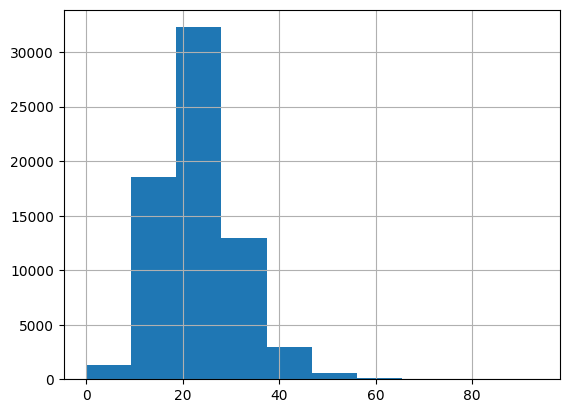

In [325]:
cgn.drop_duplicates(['UtteranceID'])['SpeechRate'].hist()

# Determine compounds

In [326]:
# find compounds in CGN
cgnCompounds = cgn.loc[cgn.WordOrtho.isin(NxN), ]
print(f'Tokens: {len(cgnCompounds.drop_duplicates(subset=["FileNameTierName", "ID"]))}')
print(f'Types: {len(cgnCompounds.drop_duplicates(subset=["WordOrtho"]))}')

Tokens: 2156
Types: 1121


# Get phonological representation left constituent

In [328]:
# For compounds in CGN, find flat morphological analysis
WordOrtho = cgnCompounds.rename(columns={'WordOrtho':'Word'})
WordOrtho = WordOrtho.drop_duplicates(subset=['FileNameTierName', 'ID'])
WordOrthoRich = WordOrtho.merge(word, on='Word', how='left')
print(WordOrthoRich[['Word', 'StrucLab', 'Imm']].head())
print(len(WordOrthoRich))

            Word                                           StrucLab  \
0        apekool                 ((aap)[N],(e)[N|N.N],(kool)[N])[N]   
1    vrouwenstem              ((vrouw)[N],(en)[N|N.N],(stem)[N])[N]   
2    bruidsschat              ((bruid)[N],(s)[N|N.N],(schat)[N])[N]   
3    bruidsschat              ((bruid)[N],(s)[N|N.N],(schat)[N])[N]   
4  levenslustige  ((leven)[N],(s)[A|N.Nx],(lust)[N],(ig)[A|NxN.]...   

               Imm  
0       aap+e+kool  
1    vrouw+en+stem  
2    bruid+s+schat  
3    bruid+s+schat  
4  leven+s+lust+ig  
2171


In [329]:
# Determine interfixes
pattern = r'\(([^)]+)\)\[[A-Za-z]+\|[A-Za-z]+\.[A-Za-z]+\]'
WordOrthoRich['StrucLab'].str.findall(pattern).drop_duplicates()

0           [e]
1          [en]
2           [s]
408     [en, e]
1223    [en, s]
1518       [er]
1522     [e, s]
Name: StrucLab, dtype: object

where does [en, s] and [e, s] come from?

In [330]:
print(WordOrthoRich.loc[WordOrthoRich.StrucLab.str.contains('\(er\)\[[A-Za-z]+\|[A-Za-z]+\.[A-Za-z]'), 'Word'])

1518     wielerbaan
1526    wielersport
Name: Word, dtype: object


In [331]:
# The stimuli above can be excluded because we're not interested in the -er- interfix
removal = ['wielerbaan', 'wielersport']
WordOrthoRich = WordOrthoRich.loc[~WordOrthoRich.Word.isin(removal), ]
print(len(WordOrthoRich))

2169


In [332]:
# as a consequence, the interfixes are
ifx = ['e', 's', 'en']

# Correct Imm column

In [333]:
print(WordOrthoRich.loc[WordOrthoRich.Imm.str.count('\+')==0, ['Word', 'WordPhono', 'Imm']])

Empty DataFrame
Columns: [Word, WordPhono, Imm]
Index: []


In [334]:
print(WordOrthoRich.loc[WordOrthoRich.Imm.str.count('\+')==1, ['Word', 'WordPhono', 'Imm']])

              Word    WordPhono            Imm
1169  volksgenoten  vOlksx@not@  volksgenoot+e


In [335]:
# add morphological analysis by hand
WordOrthoRich.loc[WordOrthoRich.Word=='volksgenoten', 'Imm'] = 'volk+s+genoten'

In [336]:
print(WordOrthoRich.loc[WordOrthoRich.Imm.str.count('\+')>2, ['Word', 'Imm']].drop_duplicates())

                     Word                     Imm
4           levenslustige         leven+s+lust+ig
334         vijfjarenplan       vijf+jaar+en+plan
404       sportfondsenbad      sport+fonds+en+bad
758       driepuntsgordel      drie+punt+s+gordel
814          levenslustig         leven+s+lust+ig
1016    zevenmijlslaarzen      zeven+mijl+s+laars
1034       drielandenpunt       drie+land+en+punt
1103  eenrichtingsverkeer  een+richting+s+verkeer
1204      tweepersoonsbed      twee+persoon+s+bed
1211      oorlogszuchtige       oorlog+s+zucht+ig
1257      eengezinswoning      een+gezin+s+woning
1777    dubbelloopsgeweer    dubbel+loop+s+geweer


In [337]:
# add morphological analysis by hand
WordOrthoRich.loc[WordOrthoRich.Word=='levenslustige', 'Imm'] = 'leven+s+lustige'
WordOrthoRich.loc[WordOrthoRich.Word=='vijfjarenplan', 'Imm'] = 'vijfjaar+en+plan'
WordOrthoRich.loc[WordOrthoRich.Word=='sportfondsenbad', 'Imm'] = 'sportfonds+en+bad'
WordOrthoRich.loc[WordOrthoRich.Word=='driepuntsgordel', 'Imm'] = 'driepunt+s+gordel'
WordOrthoRich.loc[WordOrthoRich.Word=='levenslustig', 'Imm'] = 'leven+s+lustig'
WordOrthoRich.loc[WordOrthoRich.Word=='zevenmijlslaarzen', 'Imm'] = 'zevenmijl+s+laarzen'
WordOrthoRich.loc[WordOrthoRich.Word=='drielandenpunt', 'Imm'] = 'drieland+en+punt'
WordOrthoRich.loc[WordOrthoRich.Word=='eenrichtingsverkeer', 'Imm'] = 'eenrichting+s+verkeer'
WordOrthoRich.loc[WordOrthoRich.Word=='tweepersoonsbed', 'Imm'] = 'tweepersoon+s+bed'
WordOrthoRich.loc[WordOrthoRich.Word=='oorlogszuchtige', 'Imm'] = 'oorlog+s+zuchtige'
WordOrthoRich.loc[WordOrthoRich.Word=='eengezinswoning', 'Imm'] = 'eengezin+s+woning'
WordOrthoRich.loc[WordOrthoRich.Word=='dubbelloopsgeweer', 'Imm'] = 'dubbelloop+s+geweer'

In [338]:
import numpy as np

### Determine the interfixposition
splitMorphs = WordOrthoRich['Imm'].str.split('+',expand=True)
splitMorphs['interfixPos'] = np.where(splitMorphs[1].isin(ifx), 1, 2)
splitMorphs = splitMorphs.fillna('')
print(splitMorphs.loc[splitMorphs.interfixPos==1,].head())
print(splitMorphs.loc[splitMorphs.interfixPos==2,].head())

       0   1        2  interfixPos
0    aap   e     kool            1
1  vrouw  en     stem            1
2  bruid   s    schat            1
3  bruid   s    schat            1
4  leven   s  lustige            1
Empty DataFrame
Columns: [0, 1, 2, interfixPos]
Index: []


In [339]:
# define a function to create the new columns
def get_ortho(row):
    leftOrtho = row[0]
    Interfix = row[1]
    rightOrtho = row[2]
    return pd.Series([leftOrtho, Interfix, rightOrtho])

# apply the function to each row of the dataframe and create new columns
WordOrthoRich[['leftOrtho', 'Interfix', 'rightOrtho']] = splitMorphs.apply(get_ortho, axis=1)
WordOrthoRich[['Word', 'Imm', 'leftOrtho', 'Interfix', 'rightOrtho']].head()

,Word,Imm,leftOrtho,Interfix,rightOrtho
0,apekool,aap+e+kool,aap,e,kool
1,vrouwenstem,vrouw+en+stem,vrouw,en,stem
2,bruidsschat,bruid+s+schat,bruid,s,schat
3,bruidsschat,bruid+s+schat,bruid,s,schat
4,levenslustige,leven+s+lustige,leven,s,lustige


In [340]:
# something awkward with left constituent 'ziek'
WordOrthoRich.loc[WordOrthoRich.leftOrtho.str.startswith('ziek'), ['Word', 'leftOrtho']]

,Word,leftOrtho
85,ziekenhuis,zieke
114,ziekenhuis,zieke
128,ziekenhuizen,zieke
137,ziekenzaal,zieke
201,ziekenhuis,zieke
...,...,...
2049,ziekenwagens,zieke
2060,ziekenhuis,zieke
2061,ziekenkamer,zieke
2062,ziekenhuis,zieke


In [341]:
WordOrthoRich['leftOrtho'] = np.where(WordOrthoRich.leftOrtho=='zieke',
                                     'ziek', WordOrthoRich.leftOrtho)

In [342]:
print(len(WordOrthoRich))

2169


# Get phonological representations (CELEX)

In [343]:
# remove words without phonological representations
phono = phono[phono['PhonStrsDISC'].notna()]

# remove stress symbols and exchange symbols
phono['PhonStrsDISC'] = phono['PhonStrsDISC'].str.replace("'", "")
phono['PhonStrsDISC'] = phono['PhonStrsDISC'].str.replace('-', '')

# add columns for easier merging
phono['leftOrtho'] = phono['Word']
phono['rightOrtho'] = phono['Word']
phono['leftPhonoCELEX'] = phono['PhonStrsDISC']
phono['rightPhonoCELEX'] = phono['PhonStrsDISC']
phono['wordPhonoCELEX'] = phono['PhonStrsDISC']

In [344]:
# analyze left contituent phonologically
LeftOrtho = WordOrthoRich.leftOrtho.drop_duplicates().to_list()
LeftPhonoCELEX = [x for x in LeftOrtho if x in phono.leftOrtho.to_list()]
LeftPhonoCELEX = WordOrthoRich.loc[WordOrthoRich.leftOrtho.isin(LeftPhonoCELEX),]
LeftPhonoCELEX = LeftPhonoCELEX.merge(phono[['leftOrtho', 'leftPhonoCELEX']], on='leftOrtho', how='left')
LeftPhonoCELEX = LeftPhonoCELEX.drop_duplicates('ID')

# analyze right contituent phonologically
RightOrtho = WordOrthoRich.rightOrtho.drop_duplicates().to_list()
RightPhonoCELEX = [x for x in RightOrtho if x in phono.rightOrtho.to_list()]
RightPhonoCELEX = WordOrthoRich.loc[WordOrthoRich.rightOrtho.isin(RightPhonoCELEX),]
RightPhonoCELEX = RightPhonoCELEX.merge(phono[['rightOrtho', 'rightPhonoCELEX']], on='rightOrtho', how='left')
RightPhonoCELEX = RightPhonoCELEX.drop_duplicates('ID')

In [345]:
# combine phonological transcriptions
WordOrthoRich = WordOrthoRich.merge(LeftPhonoCELEX[['ID', 'leftPhonoCELEX']], 
                                    on='ID', how='left')
WordOrthoRich = WordOrthoRich.merge(RightPhonoCELEX[['ID', 'rightPhonoCELEX']], 
                                    on='ID', how='left')

WordOrthoRich['IfixPhonoCELEX'] = np.where(WordOrthoRich['Interfix'] == 's', 's', '@')

WordOrthoRich = WordOrthoRich.merge(phono[['Word', 'wordPhonoCELEX']],
                                   on='Word', how='left')

WordOrthoRich[['Word', 'leftOrtho', 'Interfix', 'rightOrtho', 
               'wordPhonoCELEX', 'leftPhonoCELEX', 'IfixPhonoCELEX', 'rightPhonoCELEX']].drop_duplicates()

,Word,leftOrtho,Interfix,rightOrtho,wordPhonoCELEX,leftPhonoCELEX,IfixPhonoCELEX,rightPhonoCELEX
0,apekool,aap,e,kool,ap@kol,ap,@,kol
1,vrouwenstem,vrouw,en,stem,vrMw@stEm,vrMw,@,stEm
2,bruidsschat,bruid,s,schat,brLtsxAt,brLt,s,sxAt
4,levenslustige,leven,s,lustige,lev@sl}st@G@,lev@,s,l}st@G@
5,zonnegod,zon,e,god,zOn@GOt,zOn,@,xOt
...,...,...,...,...,...,...,...,...
2197,eenheidsworst,eenheid,s,worst,enhKtswOrst,enhKt,s,wOrst
2198,boodschappenjongen,boodschap,en,jongen,botsxAp@jON@,botsxAp,@,jON@
2201,bestuursorganen,bestuur,s,orgaan,b@styrsOrGan@,b@styr,s,OrGan
2202,trainingspak,training,s,pak,trenINspAk,trenIN,s,pAk


In [346]:
print(len(WordOrthoRich))

2206


In [347]:
# some constituents don't have transcriptions
print(WordOrthoRich.loc[WordOrthoRich.Word=='levensbenodigdheden', 
                  ['leftPhonoCELEX', 'IfixPhonoCELEX', 'rightPhonoCELEX']])

# .. or wrong transcription
print(WordOrthoRich.loc[WordOrthoRich.Word=='zakenlui', 
                  ['leftPhonoCELEX', 'IfixPhonoCELEX', 'rightPhonoCELEX']])

     leftPhonoCELEX IfixPhonoCELEX rightPhonoCELEX
1597           lev@              s             NaN
     leftPhonoCELEX IfixPhonoCELEX rightPhonoCELEX
1041            zak              @             mAn


In [348]:
WordOrthoRich.loc[WordOrthoRich.Word=='zakenlui', 'rightPhonoCELEX'] = 'mAn'

In [349]:
# fill na's
WordOrthoRich['leftPhonoCELEX2'] = WordOrthoRich['leftPhonoCELEX'].fillna('')
WordOrthoRich['rightPhonoCELEX2'] = WordOrthoRich['rightPhonoCELEX'].fillna('')

# combine all constituents
WordOrthoRich['composedPhono'] = WordOrthoRich.leftPhonoCELEX + WordOrthoRich.IfixPhonoCELEX + WordOrthoRich.rightPhonoCELEX

# determine length of constituents that have transcriptions
WordOrthoRich['LenIfixRight'] = WordOrthoRich.IfixPhonoCELEX.str.len() + WordOrthoRich.rightPhonoCELEX2.str.len()
WordOrthoRich['LenIfixLeft'] = WordOrthoRich.IfixPhonoCELEX.str.len() + WordOrthoRich.leftPhonoCELEX2.str.len()

# combine ifix and left or right contituents
WordOrthoRich['Left'] = WordOrthoRich.apply(
    lambda x: x['wordPhonoCELEX'][:-x['LenIfixRight']], axis=1)
WordOrthoRich['Right'] = WordOrthoRich.apply(
    lambda x: x['wordPhonoCELEX'][x['LenIfixLeft']: ], axis=1)

# fill empty transcriptions
WordOrthoRich['leftPhonoCELEX'] = np.where(WordOrthoRich.leftPhonoCELEX.isnull(), 
                                           WordOrthoRich.Left,
                                           WordOrthoRich.leftPhonoCELEX)
WordOrthoRich['rightPhonoCELEX'] = np.where(WordOrthoRich.rightPhonoCELEX.isnull(), 
                                           WordOrthoRich.Right, 
                                           WordOrthoRich.rightPhonoCELEX)
WordOrthoRich['rightPhonoCELEX'] = np.where(WordOrthoRich.composedPhono.str.len()<
                                            WordOrthoRich.wordPhonoCELEX.str.len(), 
                                           WordOrthoRich.Right, 
                                           WordOrthoRich.rightPhonoCELEX)

# check if it worked
print(WordOrthoRich.loc[WordOrthoRich.Word=='levensbenodigdheden', 
                  ['Word', 'wordPhonoCELEX', 'leftPhonoCELEX', 
                   'IfixPhonoCELEX', 'rightPhonoCELEX']])

                     Word     wordPhonoCELEX leftPhonoCELEX IfixPhonoCELEX  \
1597  levensbenodigdheden  lev@zb@nod@xthed@           lev@              s   

     rightPhonoCELEX  
1597    b@nod@xthed@  


In [350]:
# Find stimuli where right constituent starts with n or m
maskn = WordOrthoRich.rightPhonoCELEX.str.startswith('n')
maskm = WordOrthoRich.rightPhonoCELEX.str.startswith('m')

# Find stimuli where interfix is preceeded or succeeded by s or z
masksright = WordOrthoRich.rightPhonoCELEX.str.startswith('s')
maskSright = WordOrthoRich.rightPhonoCELEX.str.startswith('S')
maskzright = WordOrthoRich.rightPhonoCELEX.str.startswith('z')
masksleft = WordOrthoRich.leftPhonoCELEX.str.startswith('s')
maskSleft = WordOrthoRich.leftPhonoCELEX.str.startswith('S')
maskzleft = WordOrthoRich.leftPhonoCELEX.str.startswith('z')

# get interfixes
maskIfixs = WordOrthoRich.IfixPhonoCELEX == 's'
maskIfixe = WordOrthoRich.IfixPhonoCELEX == '@'

# remove stimuli with -en- if followed by n or m
# remove stimuli with -s- if preceeded of followed by s or z
mask = ((maskn | maskm) & maskIfixe) | ((masksright | maskSright | maskzright | masksleft | maskSleft | maskzleft) & maskIfixs)
prior = len(WordOrthoRich)
WordOrthoRich = WordOrthoRich[~mask]
post = len(WordOrthoRich)

print(f'{prior-post} of {prior} removed. New length: {post}')

308 of 2206 removed. New length: 1898


In [351]:
# check if length of leftPhono, IfixPhono, and rightPhono (all CELEX) is euqal with wordPhonoCELEX
evaluation = WordOrthoRich.wordPhonoCELEX.str.len() == (WordOrthoRich.leftPhonoCELEX.str.len() + 
                                           WordOrthoRich.IfixPhonoCELEX.str.len() + 
                                           WordOrthoRich.rightPhonoCELEX.str.len())
WordOrthoRich.loc[~evaluation, ['Word', 'leftOrtho', 'Interfix', 'rightOrtho', 'wordPhonoCELEX', 'leftPhonoCELEX', 'IfixPhonoCELEX', 
                                'rightPhonoCELEX']].drop_duplicates()

,Word,leftOrtho,Interfix,rightOrtho,wordPhonoCELEX,leftPhonoCELEX,IfixPhonoCELEX,rightPhonoCELEX
64,bejaardenhuis,bejaarde,en,huis,b@jard@hLs,b@jard@,@,hLs
371,aktentas,akte,en,tas,Akt@tAs,Akt@,@,tAs
675,bejaardentehuis,bejaarde,en,tehuis,b@jard@t@hLs,b@jard@,@,t@hLs
1061,nomadenstam,nomade,en,stam,nomad@stAm,nomad@,@,stAm
1111,bejaardenoord,bejaarde,en,oord,b@jard@ort,b@jard@,@,ort
1197,naastenliefde,naaste,en,liefde,nast@livd@,nast@,@,livd@
1203,dodenstad,dode,en,stad,dod@stAt,dod@,@,stAt
1273,klassenstelsel,klasse,en,stelsel,klAs@stEls@l,klAs@,@,stEls@l
1364,lendendoek,lende,en,doek,lEnd@duk,lEnd@,@,duk
1365,kastenstelsel,kaste,en,stelsel,kAst@stEls@l,kAst@,@,stEls@l


In [352]:
# remove left constituent's last phone if it is schwa and ifix is schwa
WordOrthoRich.leftPhonoCELEX[~evaluation] = WordOrthoRich.leftPhonoCELEX[~evaluation].apply(lambda x: x[:-1])

In [353]:
# now the transcriptions of the constituents may not be correct, but the length of the 
# constituents should be correct, which can be used to substitute some phonemes
WordOrthoRich['lenLeftPhonoCELEX'] = WordOrthoRich['leftPhonoCELEX'].str.len()
WordOrthoRich['lenIfixPhonoCELEX'] = WordOrthoRich['IfixPhonoCELEX'].str.len()
WordOrthoRich['lenRightPhonoCELEX'] = WordOrthoRich['rightPhonoCELEX'].str.len()

# substitute
WordOrthoRich['leftPhonoCELEX'] = WordOrthoRich.apply(
    lambda x: x['wordPhonoCELEX'][:x['lenLeftPhonoCELEX']], axis=1)
WordOrthoRich['IfixPhonoCELEX'] = WordOrthoRich.apply(
    lambda x: x['wordPhonoCELEX'][x['lenLeftPhonoCELEX']:x['lenLeftPhonoCELEX']+x['lenIfixPhonoCELEX']], 
    axis=1)
WordOrthoRich['rightPhonoCELEX'] = WordOrthoRich.apply(
    lambda x: x['wordPhonoCELEX'][x['lenLeftPhonoCELEX']+x['lenIfixPhonoCELEX']:], axis=1)

In [354]:
# combine all constituents
WordOrthoRich['composedPhono'] = WordOrthoRich.leftPhonoCELEX + WordOrthoRich.IfixPhonoCELEX + WordOrthoRich.rightPhonoCELEX

# check if combination of leftPhono, IfixPhono, and rightPhono (all CELEX) is euqal with wordPhonoCELEX
evaluation = WordOrthoRich.apply(lambda 
                                 row: row['wordPhonoCELEX'].startswith(row['composedPhono']), 
                                 axis=1)
WordOrthoRich.loc[~evaluation, ['Word', 'leftOrtho', 'Interfix', 'rightOrtho', 'wordPhonoCELEX', 
                  'leftPhonoCELEX', 'IfixPhonoCELEX', 'rightPhonoCELEX', 'composedPhono']
                 ].drop_duplicates()

,Word,leftOrtho,Interfix,rightOrtho,wordPhonoCELEX,leftPhonoCELEX,IfixPhonoCELEX,rightPhonoCELEX,composedPhono


In [355]:
print(len(WordOrthoRich))

1898


# Get phonological representations (CGN)

In [356]:
# remove words without phonological representations
phono = phono[phono['PhonStrsDISC'].notna()]

# remove stress symbols
phono['PhonStrsDISC'] = phono['PhonStrsDISC'].str.replace("'", "")
phono['PhonStrsDISC'] = phono['PhonStrsDISC'].str.replace('-', '')

# substitute symbols with corresponding symbols in CGN
phono['PhonStrsDISC'] = phono['PhonStrsDISC'].str.replace('M', 'A+', regex=False)
phono['PhonStrsDISC'] = phono['PhonStrsDISC'].str.replace('}', 'Y', regex=False)
phono['PhonStrsDISC'] = phono['PhonStrsDISC'].str.replace('K', 'E+', regex=False)
phono['PhonStrsDISC'] = phono['PhonStrsDISC'].str.replace('L', 'Y+', regex=False)
phono['PhonStrsDISC'] = phono['PhonStrsDISC'].str.replace('|', '2', regex=False)

# add columns for easier merging
phono['leftOrtho'] = phono['Word']
phono['rightOrtho'] = phono['Word']
phono['leftPhono'] = phono['PhonStrsDISC']
phono['rightPhono'] = phono['PhonStrsDISC']

In [357]:
# analyze left constituent phonologically
LeftOrtho = WordOrthoRich.leftOrtho.drop_duplicates().to_list()
LeftPhono = [x for x in LeftOrtho if x in phono.leftOrtho.to_list()]
LeftPhono = WordOrthoRich.loc[WordOrthoRich.leftOrtho.isin(LeftPhono),]
LeftPhono = LeftPhono.merge(phono[['leftOrtho', 'leftPhono']], on='leftOrtho', how='left')
LeftPhono = LeftPhono.drop_duplicates('ID')

# analyze right constituent phonologically
RightOrtho = WordOrthoRich.rightOrtho.drop_duplicates().to_list()
RightPhono = [x for x in RightOrtho if x in phono.rightOrtho.to_list()]
RightPhono = WordOrthoRich.loc[WordOrthoRich.rightOrtho.isin(RightPhono),]
RightPhono = RightPhono.merge(phono[['rightOrtho', 'rightPhono']], on='rightOrtho', how='left')
RightPhono = RightPhono.drop_duplicates('ID')

# analyze interfix phonologically
WordOrthoRich['IfixPhono'] = np.where(WordOrthoRich['Interfix'] == 's', 's', '@')

In [358]:
# combine phonological transcriptions
WordOrthoRich = WordOrthoRich.merge(LeftPhono[['ID', 'leftPhono']], 
                                    on='ID', how='left')
WordOrthoRich = WordOrthoRich.merge(RightPhono[['ID', 'rightPhono']], 
                                    on='ID', how='left')

In [359]:
print(len(WordOrthoRich))

1898


In [360]:
# there are still some mismatches between the CGN and CELEX transcriptions
WordOrthoRich.composedPhono = WordOrthoRich.leftPhono + WordOrthoRich.IfixPhono + WordOrthoRich.rightPhono
print(WordOrthoRich.loc[WordOrthoRich.WordPhono!=WordOrthoRich.composedPhono, ['Word', 'WordPhono', 'composedPhono']].drop_duplicates().head())

# and some  missing transcriptions:
print(WordOrthoRich.loc[WordOrthoRich.leftPhono.isnull(), ['Word', 'WordPhono']])
print(WordOrthoRich.loc[WordOrthoRich.rightPhono.isnull(), ['Word', 'WordPhono']])

               Word     WordPhono composedPhono
3          zonnegod       zOn@GOt       zOn@xOt
5          bijenwas      bE+j@wAs       bE+@wAs
7      goudsbloemen    xA+tzblum@     xA+tsblum
9   bloemenslingers  blum@slIN@rs   blum@slIN@r
11     levenskansen    lev@skAns@     lev@skans
                     Word        WordPhono
91           jakobsladder      jakOpslAd@r
295         vijfjarenplan     fE+fjar@plAn
358       sportfondsenbad   spOrtfOnts@bAt
517      conservenblikjes  kOnzErv@blIkj@s
666       driepuntsgordel   dripYntsxOrd@l
810         vijfjarenplan     vE+fjar@plAn
812         vijfjarenplan     vE+fjar@plAn
910        drielandenpunt     drilAnd@pYnt
970   eenrichtingsverkeer  enrIxtINsf@rker
1066      tweepersoonsbed    twep@rsonzbEt
1104      eengezinswoning    eNG@zInswonIN
1180  eenrichtingsverkeer  enrIxtINsf@rker
                     Word          WordPhono
1377  levensbenodigdheden  lev@sb@nod@xthed@


In [361]:
#correct entries from hand
WordOrthoRich.loc[WordOrthoRich.WordPhono=='jakOpslAd@r', 'leftPhono'] = 'jakOp'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='jakOpslAd@r', 'IfixPhono'] = 's'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='jakOpslAd@r', 'rightPhono'] = 'lAd@r'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='fE+fjar@plAn', 'leftPhono'] = 'fE+fjar'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='fE+fjar@plAn', 'IfixPhono'] = '@'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='fE+fjar@plAn', 'rightPhono'] = 'plan'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='spOrtfOnts@bAt', 'leftPhono'] = 'spOrtfOnts'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='spOrtfOnts@bAt', 'IfixPhono'] = '@'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='spOrtfOnts@bAt', 'rightPhono'] = 'bAt'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='kOnzErv@blIkj@s', 'leftPhono'] = 'kOnzErv'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='kOnzErv@blIkj@s', 'IfixPhono'] = '@'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='kOnzErv@blIkj@s', 'rightPhono'] = 'blIkj@s'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='dripYntsxOrd@l', 'leftPhono'] = 'dripYnt'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='dripYntsxOrd@l', 'IfixPhono'] = 's'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='dripYntsxOrd@l', 'rightPhono'] = 'xOrd@l'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='vE+fjar@plAn', 'leftPhono'] = 'vE+fjar'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='vE+fjar@plAn', 'IfixPhono'] = '@'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='vE+fjar@plAn', 'rightPhono'] = 'plAn'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='drilAnd@pYnt', 'leftPhono'] = 'drilAnd'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='drilAnd@pYnt', 'IfixPhono'] = '@'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='drilAnd@pYnt', 'rightPhono'] = 'pYnt'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='dripUntsxOrd@l', 'leftPhono'] = 'dripUnt'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='dripUntsxOrd@l', 'IfixPhono'] = 's'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='dripUntsxOrd@l', 'rightPhono'] = 'xOrd@l'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='enrIxtINsf@rker', 'leftPhono'] = 'enrIxtIN'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='enrIxtINsf@rker', 'IfixPhono'] = 's'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='enrIxtINsf@rker', 'rightPhono'] = 'f@rker'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='twep@rsonzbEt', 'leftPhono'] = 'twep@rson'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='twep@rsonzbEt', 'IfixPhono'] = 'z'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='twep@rsonzbEt', 'rightPhono'] = 'bEt'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='eNG@zInswonIN', 'leftPhono'] = 'eNG@zIn'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='eNG@zInswonIN', 'IfixPhono'] = 's'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='eNG@zInswonIN', 'rightPhono'] = 'wonIN'

WordOrthoRich.loc[WordOrthoRich.WordPhono=='lev@sb@nod@xthed@', 'leftPhono'] = 'lev@'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='lev@sb@nod@xthed@', 'IfixPhono'] = 's'
WordOrthoRich.loc[WordOrthoRich.WordPhono=='lev@sb@nod@xthed@', 'rightPhono'] = 'b@nod@xthed@'

Note that somtimes the CELEX transcription does not match the CGN transcription of the left constituent. Thus, the CELEX transcriptions needs to be updated. This is carried out using a fuzzy match, that is, the best possible match between the two transcriptions is found

In [362]:
import regex

# define functon for fuzzy matching
def fuzzy_match(row):
    pattern = '(' + str(row.leftPhono) + '){e<=2}'
    match_group = regex.match(pattern, row.WordPhono)
    if match_group:
        match = match_group.group(1)
    else:
        match = np.nan
    return(match)

# write results to leftPhonoFuzz
WordOrthoRich['leftPhonoFuzz'] = WordOrthoRich.apply(fuzzy_match, axis=1)
WordOrthoRich['leftPhonoFuzz'] = np.where(WordOrthoRich.leftPhonoFuzz.isna(), WordOrthoRich.leftPhono, WordOrthoRich.leftPhonoFuzz)
WordOrthoRich[['Word', 'leftOrtho', 'Interfix', 'rightOrtho', 'WordPhono', 'leftPhono', 
               'leftPhonoFuzz', 'IfixPhono', 'rightPhono']].drop_duplicates().head(10)

,Word,leftOrtho,Interfix,rightOrtho,WordPhono,leftPhono,leftPhonoFuzz,IfixPhono,rightPhono
0,apekool,aap,e,kool,ap@kol,ap,ap,@,kol
1,vrouwenstem,vrouw,en,stem,vrA+w@stEm,vrA+w,vrA+w,@,stEm
2,levenslustige,leven,s,lustige,lev@slYst@G@,lev@,lev@,s,lYst@G@
3,zonnegod,zon,e,god,zOn@GOt,zOn,zOn,@,xOt
4,zonnekind,zon,e,kind,zOn@kInt,zOn,zOn,@,kInt
5,bijenwas,bij,en,was,bE+j@wAs,bE+,bE+j,@,wAs
6,zonnerad,zon,e,rad,zOn@rAt,zOn,zOn,@,rAt
7,goudsbloemen,goud,s,bloem,xA+tzblum@,xA+t,xA+t,s,blum
9,bloemenslingers,bloem,en,slinger,blum@slIN@rs,blum,blum,@,slIN@r
10,bruidspaar,bruid,s,paar,brY+tspar,brY+t,brY+t,s,par


In [363]:
# correct lev@ to lev@n
mask = (WordOrthoRich.WordPhono.str.startswith('lev@n')) & (WordOrthoRich.leftPhonoFuzz=='lev@')
WordOrthoRich.loc[mask, 'leftPhonoFuzz'] = 'lev@n'

In [364]:
# define function to check if interfix was pronounced as z instead of s
def check_ifx(row):
    indexIfix = len(str(row['leftPhonoFuzz']))
    wordPhono = str(row['WordPhono'])
    IfixPhono = str(row['IfixPhono']) 
    if (wordPhono[indexIfix] == 'z') & (IfixPhono =='s'):
        value=True
    else:
        value=False
        
    return(value)

# write results to leftPhonoFuzz
mask = WordOrthoRich.apply(check_ifx, axis=1)
WordOrthoRich.loc[mask, 'IfixPhono'] = 'z'

In [365]:
print(len(WordOrthoRich))

1898


In [366]:
# check what else needs to be corrected
WordOrthoRich['combinedPhono2'] = WordOrthoRich.leftPhonoFuzz + WordOrthoRich.IfixPhono
mask = WordOrthoRich.apply(lambda row: row['WordPhono'].startswith(row['combinedPhono2']), axis=1)
WordOrthoRich.loc[~mask, ['Word', 'leftOrtho', 'Interfix', 'rightOrtho', 'WordPhono', 'leftPhono', 'leftPhonoFuzz', 
                                           'IfixPhono', 'rightPhono']].drop_duplicates().head(50)

,Word,leftOrtho,Interfix,rightOrtho,WordPhono,leftPhono,leftPhonoFuzz,IfixPhono,rightPhono
46,bejaardenhuis,bejaarde,en,huis,b@jard@hY+s,b@jard@,b@jard@,@,hY+s
128,vlooienband,vlo,en,band,floj@bAnt,vlo,flo,@,bAnt
133,vlooienband,vlo,en,band,vloj@bAnt,vlo,vlo,@,bAnt
328,aktentas,akte,en,tas,Akt@tAs,Akt@,Akt@,@,tAs
343,pijpestelen,pijp,e,steel,pE+pEst@l@,pE+p,pE+p,@,stel
379,bokkesprong,bok,e,sprong,bOkEsprON,bOk,bOk,@,sprON
483,huisartsengeneeskunde,huisarts,en,geneeskunde,hY+sArtsEG@neskYnd@,hY+sArts,hY+sArts,@,x@neskYnd@
590,bejaardentehuis,bejaarde,en,tehuis,b@jard@t@hY+s,b@jard@,b@jard@,@,t@hY+s
725,studententijd,student,en,tijd,stydEntEtE+t,stydEnt,stydEnt,@,tE+t
796,huwelijksleven,huwelijk,s,leven,hyw@l@E+kslev@,hyw@l@k,hyw@l@E,s,lev@


In [367]:
# define function to check if interfix is added also to left constituent
def check_ifx(row):
    indexLast = len(str(row['leftPhonoFuzz']))-1
    wordPhono = str(row['WordPhono'])
    IfixPhono = str(row['IfixPhono']) 
    if (wordPhono[indexLast] == '@') & (IfixPhono =='@'):
        value=True
    else:
        value=False
        
    return(value)

# write results to leftPhonoFuzz
mask = WordOrthoRich.apply(check_ifx, axis=1)
WordOrthoRich.loc[mask, 'leftPhonoFuzz'] = WordOrthoRich.apply(lambda x: x['leftPhonoFuzz'][:-1], axis = 1)

In [368]:
# define function to check if schwa is pronounced as E
def check_ifx(row):
    indexIfix = len(str(row['leftPhonoFuzz']))
    wordPhono = str(row['WordPhono'])
    IfixPhono = str(row['IfixPhono']) 
    if (wordPhono[indexIfix] == 'E') & (IfixPhono =='@'):
        value=True
    else:
        value=False
        
    return(value)

# write results to leftPhonoFuzz
mask = WordOrthoRich.apply(check_ifx, axis=1)
WordOrthoRich.loc[mask, 'IfixPhono'] = 'E'

In [369]:
# check what else needs to be corrected
WordOrthoRich['combinedPhono2'] = WordOrthoRich.leftPhonoFuzz + WordOrthoRich.IfixPhono
mask = WordOrthoRich.apply(lambda row: row['WordPhono'].startswith(row['combinedPhono2']), axis=1)
incorr = WordOrthoRich.loc[~mask, ['Word', 'WordPhono', 'leftPhonoFuzz', 'IfixPhono']].drop_duplicates()
print(incorr.head())
len(incorr)

                Word       WordPhono leftPhonoFuzz IfixPhono
128      vlooienband       floj@bAnt           flo         @
133      vlooienband       vloj@bAnt           vlo         @
796   huwelijksleven  hyw@l@E+kslev@       hyw@l@E         s
1155       hondsdraf        hOnzdrAf          hOnz         s
1161    gezichtspunt       x@zIxspYn        x@zIxs         s


47

In [370]:
print(len(WordOrthoRich))

1898


In [371]:
# export the words for manual correction
RUN=False
if RUN:
    incorr.to_csv('../DataProcessed/cgn_incorrect_comp-o.csv', sep='\t')

In [372]:
# import the corrected words
corr = pd.read_csv('../DataProcessed/cgn_correct_comp-o.csv', sep='\t', index_col=0)
corr.head()

,Word,WordPhono,leftPhonoFuzz,IfixPhono
107,vlooienband,floj@bAnt,floj,@
111,vlooienband,vloj@bAnt,vloj,@
487,huwelijksleven,hyw@l@E+kslev@,hyw@l@E+k,s
673,hondsdraf,hOnzdrAf,hOn,z
677,gezichtspunt,x@zIxspYn,x@zIx,s


In [373]:
WordOrthoRich['IfixPhonoFuzz'] = WordOrthoRich.IfixPhono

# overwrite pandas dataframe with corrected dataframe
for index, row in corr.iterrows():
    phonoCorr = row['WordPhono']
    leftPhonoCorr = row['leftPhonoFuzz']
    IfixPhonoCorr = row['IfixPhono']
    WordOrthoRich.loc[WordOrthoRich.WordPhono==phonoCorr, 'leftPhonoFuzz'] = leftPhonoCorr
    WordOrthoRich.loc[WordOrthoRich.WordPhono==phonoCorr, 'IfixPhono'] = IfixPhonoCorr
    
WordOrthoRich.loc[WordOrthoRich.WordPhono=='hyw@l@E+kslev@' ,]

,FileNameTierName,ID,Word,WordPhono,Phone,PhoneStart,PhoneEnd,variant,WordStart,WordEnd,...,Right,lenLeftPhonoCELEX,lenIfixPhonoCELEX,lenRightPhonoCELEX,IfixPhono,leftPhono,rightPhono,leftPhonoFuzz,combinedPhono2,IfixPhonoFuzz
796,fn001505.awdN00794,143-huwelijksleven.,huwelijksleven,hyw@l@E+kslev@,h,46.042,46.072,Netherlandic,46.042,46.779,...,lev@,7,1,4,s,hyw@l@k,lev@,hyw@l@E+k,hyw@l@Es,s
1002,fn001043.awdN00543,836-huwelijksleven.,huwelijksleven,hyw@l@E+kslev@,h,299.447,299.498,Netherlandic,299.447,300.265,...,lev@,7,1,4,s,hyw@l@k,lev@,hyw@l@E+k,hyw@l@Es,s


In [374]:
# define function to get rightPhono
def right_phono(row):
    leftLength = len(str(row['leftPhonoFuzz']))
    ifxLength = len(str(row['IfixPhono']))
    wordPhono = str(row['WordPhono'])
    rightPhono = wordPhono[leftLength+ifxLength:]
        
    return(rightPhono)

WordOrthoRich['rightPhonoFuzz'] = WordOrthoRich.apply(right_phono, axis=1)

# merge dataframe and write to file

In [375]:
# investigate observations that were removed after the analysis
allCompounds = cgnCompounds.WordOrtho.drop_duplicates().to_list()
analyzedCompounds = WordOrthoRich.Word.drop_duplicates().to_list()
[x for x in allCompounds if x not in analyzedCompounds]

['bruidsschat',
 'kleermakerszit',
 'eenheidsstaten',
 'vrouwennamen',
 'dorpsstraat',
 'stationsplein',
 'zonsopgang',
 'zonsondergang',
 'mensenmassa',
 'kwajongensstreken',
 'zeemansleven',
 'stadsmensen',
 'burgemeester',
 'stadsmuren',
 'meisjesstemmen',
 'prullenmand',
 'schaapskooien',
 'gezondheidszorg',
 'bloemenmand',
 'voedingssupplementen',
 'zakenman',
 'staatslieden',
 'staatsgreep',
 'rechtszaak',
 'stadskern',
 'geuzennaam',
 'stadspoort',
 'oorlogsschepen',
 'scheepsruim',
 'scheepshelling',
 'standsverschil',
 'schildersezel',
 'kapperszaak',
 'verzetsstrijders',
 'zondagsschool',
 'oorlogssituatie',
 'garnizoensstad',
 'slagersknecht',
 'rechtsstelsel',
 'stadsbus',
 'zonsondergangen',
 'dierenmishandeling',
 'scheepswerf',
 'machtsstrijd',
 'lichaamscellen',
 'voedingsstoffen',
 'elektronenmicroscoop',
 'rechtszaken',
 'volksziekte',
 'samenlevingsvormen',
 'scheepsjongen',
 'passagiersschip',
 'sprookjesfiguur',
 'schoonheidsbehandeling',
 'schoonheidsmiddelen',
 '

In [376]:
# delete columns
del WordOrthoRich['leftPhono']
del WordOrthoRich['rightPhono']

# rename columns
WordOrthoRich = WordOrthoRich.rename(columns={'leftPhonoFuzz':'leftPhono',
                                              'rightPhonoFuzz':'rightPhono'})
WordOrthoRich[['Word', 'WordPhono', 'leftPhono', 'IfixPhono', 'rightPhono', 
               'wordPhonoCELEX', 'leftPhonoCELEX', 'IfixPhonoCELEX', 'rightPhonoCELEX']]

,Word,WordPhono,leftPhono,IfixPhono,rightPhono,wordPhonoCELEX,leftPhonoCELEX,IfixPhonoCELEX,rightPhonoCELEX
0,apekool,ap@kol,ap,@,kol,ap@kol,ap,@,kol
1,vrouwenstem,vrA+w@stEm,vrA+w,@,stEm,vrMw@stEm,vrMw,@,stEm
2,levenslustige,lev@slYst@G@,lev@,s,lYst@G@,lev@sl}st@G@,lev@,s,l}st@G@
3,zonnegod,zOn@GOt,zOn,@,GOt,zOn@GOt,zOn,@,GOt
4,zonnekind,zOn@kInt,zOn,@,kInt,zOn@kInt,zOn,@,kInt
...,...,...,...,...,...,...,...,...,...
1893,levensverhaal,lev@nsf@rhal,lev@n,s,f@rhal,lev@sf@rhal,lev@,s,f@rhal
1894,bestuursorganen,b@styrzOrGan@n,b@styr,z,OrGan@n,b@styrsOrGan@,b@styr,s,OrGan@
1895,trainingspak,trenINspAk,trenIN,s,pAk,trenINspAk,trenIN,s,pAk
1896,godsnaam,GOtsnam=,GOt,s,nam=,xOtsnam,xOt,s,nam


In [377]:
# merge analysis with main dataframe
WordOrthoSmall = WordOrthoRich[['FileNameTierName', 'ID', 'leftOrtho', 'Interfix', 'rightOrtho', 
                                'IfixPhono', 'leftPhono', 'rightPhono',
                               'wordPhonoCELEX', 'leftPhonoCELEX', 'IfixPhonoCELEX', 'rightPhonoCELEX']]
dfFinal = cgnCompounds.merge(WordOrthoSmall, on=['FileNameTierName', 'ID'], how='inner')

In [378]:
tokensS = len(dfFinal.loc[dfFinal.IfixPhono.isin(['z', 's']), ['FileNameTierName', 'ID']].drop_duplicates())
typesS = len(dfFinal.loc[dfFinal.IfixPhono.isin(['z', 's']), 'WordOrtho'].drop_duplicates())
tokensEn = len(dfFinal.loc[dfFinal.IfixPhono.isin(['E', '@', '@n']), ['FileNameTierName', 'ID']].drop_duplicates())
typesEn = len(dfFinal.loc[dfFinal.IfixPhono.isin(['E', '@', '@n']), 'WordOrtho'].drop_duplicates())

print(f'Number of unique types with s: {typesS} ({tokensS} tokens)')
print(f'Number of unique types with en: {typesEn} ({tokensEn} tokens)')

Number of unique types with s: 591 (1018 tokens)
Number of unique types with en: 368 (828 tokens)


In [379]:
dfFinal.head(20)

,FileNameTierName,ID,WordOrtho,WordPhono,Phone,PhoneStart,PhoneEnd,variant,WordStart,WordEnd,...,leftOrtho,Interfix,rightOrtho,IfixPhono,leftPhono,rightPhono,wordPhonoCELEX,leftPhonoCELEX,IfixPhonoCELEX,rightPhonoCELEX
0,fn001092.awdN00551,182-apekool.,apekool,ap@kol,a,57.578,57.700,Netherlandic,57.578,58.176,...,aap,e,kool,@,ap,kol,ap@kol,ap,@,kol
1,fn001092.awdN00551,182-apekool.,apekool,ap@kol,p,57.700,57.771,Netherlandic,57.578,58.176,...,aap,e,kool,@,ap,kol,ap@kol,ap,@,kol
2,fn001092.awdN00551,182-apekool.,apekool,ap@kol,@,57.771,57.822,Netherlandic,57.578,58.176,...,aap,e,kool,@,ap,kol,ap@kol,ap,@,kol
3,fn001092.awdN00551,182-apekool.,apekool,ap@kol,k,57.822,57.953,Netherlandic,57.578,58.176,...,aap,e,kool,@,ap,kol,ap@kol,ap,@,kol
4,fn001092.awdN00551,182-apekool.,apekool,ap@kol,o,57.953,58.136,Netherlandic,57.578,58.176,...,aap,e,kool,@,ap,kol,ap@kol,ap,@,kol
5,fn001092.awdN00551,182-apekool.,apekool,ap@kol,l,58.136,58.176,Netherlandic,57.578,58.176,...,aap,e,kool,@,ap,kol,ap@kol,ap,@,kol
6,fn001092.awdN00551,251-vrouwenstem,vrouwenstem,vrA+w@stEm,v,79.356,79.448,Netherlandic,79.356,80.219,...,vrouw,en,stem,@,vrA+w,stEm,vrMw@stEm,vrMw,@,stEm
7,fn001092.awdN00551,251-vrouwenstem,vrouwenstem,vrA+w@stEm,r,79.448,79.510,Netherlandic,79.356,80.219,...,vrouw,en,stem,@,vrA+w,stEm,vrMw@stEm,vrMw,@,stEm
8,fn001092.awdN00551,251-vrouwenstem,vrouwenstem,vrA+w@stEm,A+,79.510,79.664,Netherlandic,79.356,80.219,...,vrouw,en,stem,@,vrA+w,stEm,vrMw@stEm,vrMw,@,stEm
9,fn001092.awdN00551,251-vrouwenstem,vrouwenstem,vrA+w@stEm,w,79.664,79.726,Netherlandic,79.356,80.219,...,vrouw,en,stem,@,vrA+w,stEm,vrMw@stEm,vrMw,@,stEm


In [381]:
# write to csv
dfFinal.to_csv(outfile, sep='\t')